# Biogeoscience case study

The two case studies in this folder from climate science and biogeosciences follow the QAD-questionnaire and method-selection flow chart in the following Review paper (included in the tigramite github tutorial folder):

Runge, J., Gerhardus, A., Varando, G., Eyring, V. & Camps-Valls, G. Causal inference for time series. Nat. Rev. Earth Environ. 10, 2553 (2023).

A list of methods with software to address selected QAD problems appears at the end of that Review paper.

This example will demonstrate the use of causal inference based techniques to investigate the causal effect of air temperature (Tair) on ecosystem respiration (Reco) from data that also includes gross primary production (GPP) and shortwave radiation (Rg). To better illustrate non-parametric causal effect estimation, this case study considers a synthetic system with known quantitative ground truth:

\begin{align}\label{eq:biogeoscience_model}
\begin{split}
\text{Rg}_t &= \lvert 280~\sin(t \pi /365)^2 + 50~\lvert\sin(t \pi /365)\rvert\eta^{\text{Rg}}_t\rvert \\
\text{Tair}_t &= 0.8~\text{Tair}_{t-1} + 0.02~\text{Rg}_t + 5 \eta^{\text{Tair}}_t \\
\text{GPP}_t &= \lvert 0.2~\text{GPP}_{t-1} + 0.002~\text{Tair}_t~\text{Rg}_t + 3 \eta^{\text{GPP}}_t \rvert \\ 
\text{Reco}_t &= \lvert 0.3~\text{Reco}_{t-1} + 0.9~\text{GPP}_t~0.8^{0.12(\text{Tair}_t-15)} + 2 \eta^{\text{Reco}}_t \rvert
\end{split}
\end{align}

In these equations, which are interpreted as an SCM, the $\eta^{\cdot}_t$ are mutually independent standard normal noise terms, except for Tair where $\eta^{\text{Tair}}_t=\eta_t+\frac{1}{4}\epsilon_t^3$ (standard normal noises $\eta$ and $\epsilon$) with a cubic exponent to represent more extreme temperatures. The SCM exhibits a unimodal relationship between Reco and Tair (see the interventional ground truth in the figures below), which has also been found in real data (see paper).

The analysis will first illustrate causal discovery and then causal effect estimation. Let's start with some imports of standard python packages as well as the tigramite causal inference package.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms

import sys
from copy import deepcopy

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore')

import tigramite
import tigramite.data_processing as pp
import tigramite.plotting as tp

from tigramite.models import LinearMediation, Models
from tigramite.causal_effects import CausalEffects

from tigramite.pcmci import PCMCI
from tigramite.independence_tests.robust_parcorr import RobustParCorr

## Data generation and plotting

The steps closely follow the QAD-template (Tab. 1 and Fig. 2 flow chart in Review paper). As opposed to the climate example, here all variables (nodes) are already defined as daily continuously-valued time series. The next question is about creating a stationary dataset (Fig. 2 flow chart). Unlike in the climate example, here a setting with multiple datasets (multiple sites) is considered. In the considered synthetic example, stationarity is fulfilled by construction (apart from seasonality shared by all sites), as the sites are just different realizations of the same SCM. Hence, the time series from the different sites can be simply aggregated (pooled). To alleviate the seasonal non-stationarity, only the period April-September (model months) is considered (see figure below).

In [2]:
# Time series length is 6 years
T = 365*6 + 1

# 4 Variables
N = 4

# We model 5 measurement sites
M = 5

data_dict = {}
mask_dict = {}
for site in range(M):

    modeldata_mask = np.ones((T, N), dtype='int')
    for t in range(T):
        # April to September
        if 90 <= t % 365 <= 273:
            modeldata_mask[t,:] = 0
            
    mask_dict[site] = modeldata_mask

    modeldata = np.zeros((T,N))
    random_state = np.random.RandomState(site)
    noise = random_state.randn(T, N)
    noise[:, 1] += 0.25*random_state.randn(T)**3
        
    for t in range(1, T):
        modeldata[t,0] = np.abs(280.*np.abs(np.sin((t)*np.pi/365.))**2 + 50.*np.abs(np.sin(t*np.pi/365.))*noise[t,0])
        modeldata[t,1] = 0.8*modeldata[t-1,1] + 0.02*modeldata[t,0] + 5*noise[t,1]  
        modeldata[t,2] = np.abs(0.2* modeldata[t-1, 2] + 0.002*modeldata[t,0] * modeldata[t,1] + 3*noise[t,2]) 
        modeldata[t,3] = np.abs(0.3*modeldata[t-1,3] + 0.9*modeldata[t,2] * 0.8**(0.12*(modeldata[t,1]-15)) + 2*noise[t,3])
    data_dict[site] = modeldata

# Variable names
var_names = ['Rg', 'Tair', 'GPP', 'Reco']

# Init Tigramite dataframe object
dataframe = pp.DataFrame(data=data_dict, 
                    mask = mask_dict,
                    analysis_mode = 'multiple',
                    var_names=var_names)

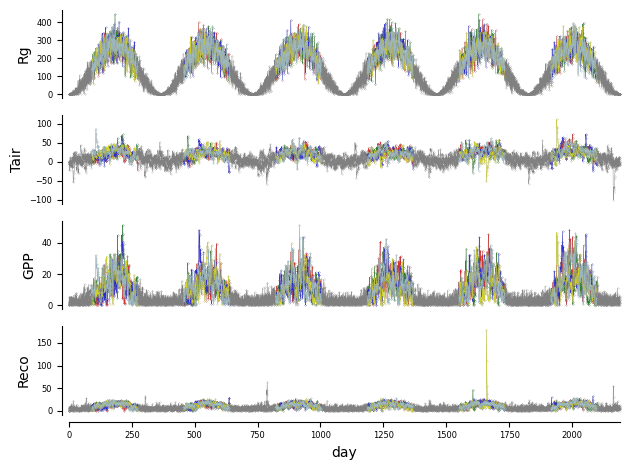

In [3]:
fig_axes = tp.plot_timeseries(dataframe,
                   grey_masked_samples='data',
                   adjust_plot=False,
                   color = 'red',
                   alpha=0.6, 
                   data_linewidth=0.3,
                   selected_dataset=0)

for index in range(1, len(data_dict)):
    adjust_plot = False
    if index == M - 1: 
        adjust_plot = True
    color = ['red', 'green', 'blue', 'yellow', 'lightblue'][index]
    tp.plot_timeseries(dataframe,
                       fig_axes =fig_axes,
                       grey_masked_samples='data',
                       adjust_plot=adjust_plot,
                       color=color,
                       time_label='day',
                       alpha=0.6, 
                       data_linewidth=0.3,
                       selected_dataset=index)
plt.show()

The grey samples are masked out. Note the extreme values occuring due to nonlinearities.

## Causal discovery analysis

Given this stationary dataset, the first causal question is about causal discovery. To choose the appropriate causal discovery method, assumptions that can reasonably be made must be determined. 

### Stationarity assumption, determinism, latent confounders

The data here comes from multiple datasets (blue box in the causal discovery frame, Fig. 2 in paper), however, the datasets share the same underlying distribution and the next question is whether this system is deterministic. Given the complexity of the dynamics at this scale, it can be assumed to be a non-deterministic system. The next assumption to be made is whether or not there might be hidden confounders, that is, unobserved variables that causally influence two or more observed variables. Here, due to restricting the analysis to seasons across which stationarity can be expected, it is reasonable to assume the absence of hidden confounding, which is true in the underlying SCM. 

### Structural assumptions

The structural assumption of the graph type then needs to be made. As the processes here are fast, contemporaneous causal effects (that is, causal influences on a time scale below the data's time resolution of 1 day) might occur. Further, here the domain knowledge that Rg is exogeneous can be enforced by not allowing any parents of Rg in the graph. These assumptions suggest using the constraint-based causal discovery algorithm PCMCI$^+$ (or other similar options, Fig. 2). 

To make an assumption on the maximal time lag in the causal time series graph estimated by PCMCI$^+$ (that is, the maximum over all $\tau$ such that $X^i_{t-\tau} \to X^j_t$ is in the graph), data can be used to investigate the lagged dependency functions, or, as done here, domain knowledge can be used to justify $\tau_{\max}=1$ (in units of days). 

### Parametric assumptions

The next hyperparameter choice for PCMCI$^+$ is about the conditional independence test, which requires a parametric assumption. Below we use Tigramite's ``plot_densities`` function to investigate the type of dependencies via joint and marginal density estimation. Here we depict the raw data as well as transformed data that achieves normally-distributed marginals.

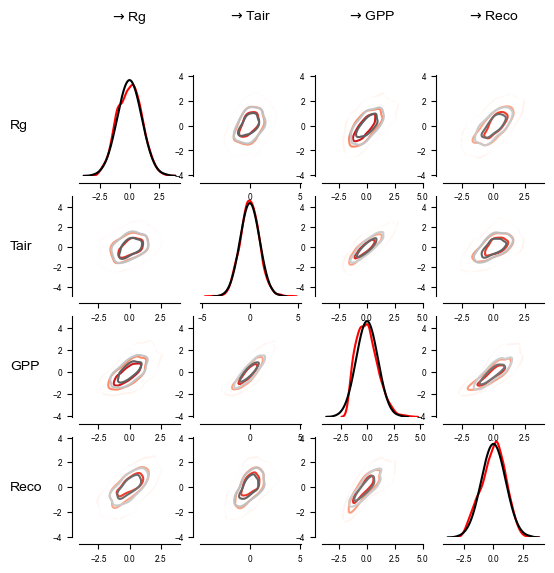

In [4]:
dataframe_here = deepcopy(dataframe)
matrix_lags = None
matrix = tp.setup_density_matrix(N=N, 
        var_names=dataframe.var_names, **{
        'figsize':(6, 6), 
        'tick_label_size':6,
        'label_space_left':0.18})

# Standardize data to make it comparable
data_dict_here = deepcopy(data_dict)
for m in data_dict_here.keys():
    mean, std = pp.weighted_avg_and_std(data_dict_here[m], axis=0, weights=(mask_dict[m]==False))

    data_dict_here[m] -= mean
    data_dict_here[m] /= std

dataframe_here = pp.DataFrame(data_dict_here,
        analysis_mode='multiple',
     mask=mask_dict, var_names=var_names,)

matrix.add_densityplot(dataframe=dataframe_here, 
    matrix_lags=matrix_lags, label_color='red', 
    snskdeplot_args = {'cmap':'Reds', 'alpha':1., 'levels':4})

# Now transform data to normal marginals
data_normal = deepcopy(data_dict)
for m in data_normal.keys():
    data_normal[m] = pp.trafo2normal(data_dict[m], mask=mask_dict[m])
dataframe_normal = pp.DataFrame(data_normal,
    analysis_mode='multiple',
 mask=mask_dict, var_names=var_names)

matrix.add_densityplot(dataframe=dataframe_normal, 
    matrix_lags=matrix_lags, label_color='black', 
    snskdeplot_args = {'cmap':'Greys', 'alpha':1., 'levels':4})

# matrix.adjustfig(name="data_density.pdf', show_labels=False)

The marginal densities (red) are slightly non-normal. By transforming the variables such that their marginals are normally distributed, the resulting joint densities are reasonably linear. Here there are only small differences, but these can nevertheless affect the conditional independence tests. Therefore, conditional independence tests in PCMCI$^+$ should be undertaken with a robust partial correlation (RobustParCorr) here, which is a variant of partial correlation where the variables are first transformed to normally-distributed marginals.

### Sliding window analysis with PCMCIplus

The data from all sites and all of the six years can now be used to estimate a single causal graph. Alternatively, a sliding window analysis should be considered if non-stationarity of the causal graph could be present. More for illustrative purposes, a sliding window analysis is applied here that learns five causal graphs, each by combing data from two successive of the six years and across all sites (hence $5 = 6-1$ graphs, each estimated from $n=1840$ samples due to masking).

In [5]:
# Maximum time lag
tau_max = 1

# Conditional independence test
cond_ind_test = RobustParCorr(mask_type='y', verbosity=0)

# Significance level
pc_alpha = 0.05

# Stepsize of sliding window (this can be chosen as desired)
window_step = 365*1

# Length of sliding window (this should strive a balance between enough samples and 
# the window-length over which stationarity can be assumed, which, however, is not relevant in our example)
window_length = 365*2

# First set link assumptions to remove parents of Rg
# link_assumptions = None
# See the tutorial on link assumptions in the overview tutorial
link_assumptions_absent_link_means_no_knowledge = {0: {(i, -tau):'' for i in range(N) for tau in range(0, tau_max+1) if not (i==0 and tau==0)}}
link_assumptions =  PCMCI.build_link_assumptions(link_assumptions_absent_link_means_no_knowledge=link_assumptions_absent_link_means_no_knowledge,
                                   n_component_time_series=N,
                                   tau_max=tau_max,
                                   tau_min=0)
for j in link_assumptions:
    print(f"Assumed links of {j}: {link_assumptions[j]}")


Assumed links of 0: {}
Assumed links of 1: {(0, 0): 'o?o', (0, -1): 'o?>', (1, -1): 'o?>', (2, 0): 'o?o', (2, -1): 'o?>', (3, 0): 'o?o', (3, -1): 'o?>'}
Assumed links of 2: {(0, 0): 'o?o', (0, -1): 'o?>', (1, 0): 'o?o', (1, -1): 'o?>', (2, -1): 'o?>', (3, 0): 'o?o', (3, -1): 'o?>'}
Assumed links of 3: {(0, 0): 'o?o', (0, -1): 'o?>', (1, 0): 'o?o', (1, -1): 'o?>', (2, 0): 'o?o', (2, -1): 'o?>', (3, -1): 'o?>'}


In [6]:
# Initialize PCMCI class
pcmci = PCMCI(
        dataframe=dataframe, 
        cond_ind_test=cond_ind_test,
        verbosity=0)

method_args={'tau_min':0, 'tau_max':tau_max, 
            'pc_alpha':pc_alpha,
            'link_assumptions':link_assumptions,
            }

# Run sliding window PCMCIplus
summary_results = pcmci.run_sliding_window_of(method='run_pcmciplus', 
                                            method_args=method_args, 
                                            window_step=window_step,
                                            window_length=window_length,
                                            conf_lev = 0.9)

The following code places the sliding window graphs under the time series.

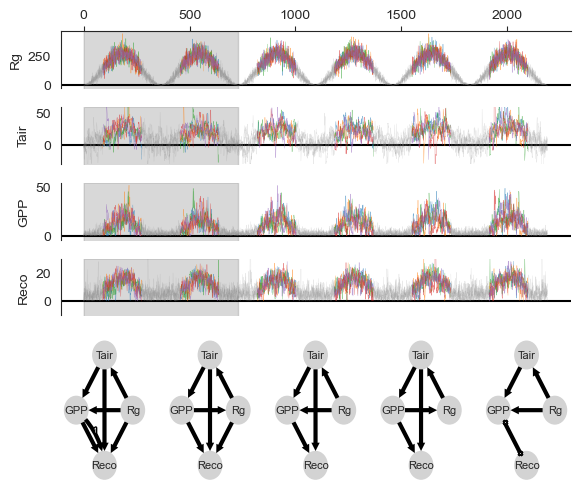

In [7]:
node_pos = None
            #  {
            # 'y': np.array([0.5, 0., 0.5, 1.]),
            # 'x': np.array([0., 0.5, 1., .5])
            # }
            
graphs = summary_results['window_results']['graph']
val_matrices = summary_results['window_results']['val_matrix']
n_windows = len(graphs)

mosaic = [['data %s' %j for i in range(n_windows)] for j in range(N)]
mosaic.append(['graph %s' %i for i in range(n_windows)])

fig, axs = plt.subplot_mosaic(mosaic = mosaic, 
                              figsize=(6, 5.),  #(6.5, 4.)
                              gridspec_kw={'height_ratios' : [0.6/N for i in range(N)] + [0.4]
                               } ,)

reference = np.where(np.fromiter(dataframe.time_offsets.values(), dtype=int) == 0)[0][0]

for j in range(N):
    ax = axs['data %s' %j]
    trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
    ax.axhline(0., color='black')

    ref_datatime = dataframe.datatime[reference]
    len_ref = len(ref_datatime)

    w = 0
    ax.fill_between(x=ref_datatime, y1=-1, y2=1, 
            where=(np.arange(len_ref) >= w*window_step)*(np.arange(len_ref) < w*window_step+window_length), color='grey', 
                    alpha=0.3, zorder=-5,
            transform=trans)

    color = 'black'
    for idata in range(dataframe.M):
        data = deepcopy(dataframe.values[idata])
        mask = dataframe.mask[idata].copy()
        datatime = dataframe.datatime[idata].copy()
        # print(data.shape, datatime.shape, T,)

        masked_data = deepcopy(data) #.copy()
        data[mask==1] = np.nan
        masked_data[mask==0] = np.nan
        if j == 0: label = "Site %d" %(idata + 1)
        else: label = None
        ax.plot(datatime, data[:,j], label = label, lw=0.3, alpha=0.6, clip_on=True) #, color=color)
        ax.plot(datatime, masked_data[:,j], color='grey', lw=0.3, alpha=0.2, clip_on=True) #, color=color)

    if j == 0: 
        for loc, spine in ax.spines.items():
            if loc not in ['left', 'top']:
                spine.set_color("none")
        ax.xaxis.tick_top()
    else:
        ax.xaxis.set_ticks([]) 
        for loc, spine in ax.spines.items():
            if loc not in ['left']:
                spine.set_color("none")  


    ax.set_ylabel(var_names[j])

    if j == 1: ax.set_ylim(-30, 60)
    if j == 3: ax.set_ylim(None, 30)


for w in range(n_windows):
    if w == 0: show_colorbar=False
    else: show_colorbar = False
    tp.plot_graph(graphs[w], 
        # val_matrix=val_matrices[w], 
        var_names=var_names,
        show_colorbar=False,  #show_colorbar
        node_label_size=8,
        node_size=0.5,
        arrow_linewidth=3.0,
        link_label_fontsize=5,
        fig_ax=(fig, axs['graph %s' %w]))

fig.subplots_adjust(left=0.12, right=0.97, bottom=0.02, top = 0.93, wspace=0.2, hspace=0.25)

When compared with the ground truth from the model equations, there are errors in the individual sliding window graphs: The first graph has a false positive, other graphs have the Rg $\to$ GPP link in the wrong direction. The last graph has a conflict link (plus-signs at the ends) due to conflicting link orientation rules within PCMCIplus.
Such errors reflect the variance of the method due to finite samples. But they can also result from wrong assumptions. For example, the model here is nonlinear, but, after the normal-marginals transformation, linearity is still a good approximation.

### Aggregated causal graph

The sliding window method ``pcmci.run_sliding_window_of`` also returns an aggregated graph consisting of the most frequent link types (including absent links) across the five sliding window graphs. Edge width indicates the frequency of the link type. This aggregated graph agrees with the ground-truth.

Further options are non-parametric independence tests (see tutorial on independence tests), but there is a trade-off between more sophisticated parametric models and their computational and sample size demands. Finally, in a more realistic scenario, there might be some unobserved confounders. In such cases, a method for causal discovery in the presence of hidden confounders can be used, for example, LPCMCI. Such more generally applicable algorithms will, however, generally come at the cost of a lower detection power.

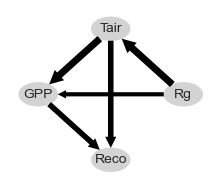

In [8]:
# Plot aggregated graph ("summary results")
val_tmp = np.abs(summary_results['summary_results']['val_matrix_mean'])
val_tmp[range(len(var_names)), range(len(var_names)), :] = 0.
cross_max = np.abs(val_tmp).max()

graph = summary_results['summary_results']['most_frequent_links']
link_width = summary_results['summary_results']['link_frequency']
fig, ax = tp.plot_graph(
    graph = graph,
    # val_matrix=summary_results['summary_results']['val_matrix_mean'],
    show_colorbar=False,
    link_width=link_width,
    cmap_edges = 'RdBu_r',
    arrow_linewidth=5,
    node_pos = node_pos,
    node_size=0.35,
    node_aspect=1.5,
    var_names=var_names,
    vmin_edges = -1, # -cross_max,
    vmax_edges = 1, # cross_max,
    node_ticks=0.5,
    edge_ticks=1.,
    label_fontsize = 8,
    node_colorbar_label='Auto-RobParCorr',
    link_colorbar_label='Cross-RobParCorr',
    figsize=(2.6, 2.2),
    # network_lower_bound=0.3,
    )

## Non-parametric causal effect estimation

The second causal question is about total causal effect estimation ([tutorial](https://github.com/jakobrunge/tigramite/blob/master/tutorials/causal_effect_estimation/tigramite_tutorial_general_causal_effect_analysis.ipynb)). According to the QAD flow chart (Fig. 2 in paper), this estimation requires knowledge of the causal time series graph. Using the causally discovered time series graph above, the goal is to estimate the causal effect of Tair (red) on Reco (blue) at lag zero. Now all of the data ($n=1840\times 3$ samples) is utilized, which is stationary (from the same distribution) because the winter season is masked away. 

### Assumed graph and adjustment set

We could get the graph using ``summary_results['summary_results']['most_frequent_links']``, but if this contains unoriented or conflicting edges, the causal effect analysis does not work and you need to orient the links yourself. The format is as follows:

In [9]:
original_graph = np.array([[['', ''],
                            ['-->', ''],
                            ['-->', ''],
                            ['', '']],

                           [['<--', ''],
                            ['', '-->'],
                            ['-->', ''],
                            ['-->', '']],

                           [['<--', ''],
                            ['<--', ''],
                            ['', '-->'],
                            ['-->', '']],

                           [['', ''],
                            ['<--', ''],
                            ['<--', ''],
                            ['', '-->']]], dtype='<U3')

# Append lag for nicer plots that include another time lag
added = np.zeros((4, 4, 1), dtype='<U3')
added[:] = ""
original_graph = np.append(original_graph, added , axis=2)

# We will assume different adaptions of this graph, starting with the unchanged version
graph = np.copy(original_graph)

The following initializes the ``CausalEffects`` class

In [10]:
# We are interested in lagged total effect of X on Y
X = [(1, 0)]
Y = [(3, 0)]
causal_effects = CausalEffects(graph, graph_type='stationary_dag',
                    X=X, Y=Y, 
                   verbosity=0)

The graph has no hidden confounders, but the effect is nonlinear, which suggests the optimal adjustment method. Let's plot this graph including the optimal adjustment set and mediators.

X = [('Tair', 0)] -----> Y = [('Reco', 0)]
Oset =  [('GPP', -1), ('Reco', -1), ('Rg', 0)]
Optimality = True
Mediators = {(2, 0)}


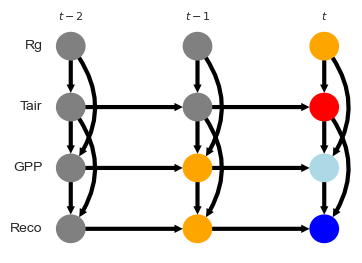

In [11]:
opt = causal_effects.get_optimal_set()
if opt is False: print("NOT IDENTIFIABLE!")
print("X = %s -----> Y = %s" % (str([(var_names[var[0]], var[1]) for var in X]), str([(var_names[var[0]], var[1]) for var in Y])))
print("Oset = ", [(var_names[v[0]], v[1]) for v in opt])
print("Optimality = %s" %str(causal_effects.check_optimality()))
print("Mediators = %s" %str(causal_effects.M))

special_nodes = {}
for node in causal_effects.X:
    special_nodes[node] = 'red'
for node in causal_effects.Y:
    special_nodes[node] = 'blue'
for node in opt:
    special_nodes[node] = 'orange'
for node in causal_effects.M:
    special_nodes[node] = 'lightblue'

link_width = None

fig, ax = tp.plot_time_series_graph(
    # graph = pcmcires['graph'],
    # val_matrix=pcmcires['val_matrix'],
    graph = causal_effects.stationary_graph,
    # graph = causal_effects.graph,
    link_width=link_width,
#     link_attribute=graph_attr,
    cmap_edges = 'RdBu_r',
    arrow_linewidth=3,
    curved_radius=0.4,
    node_size=0.15,
    special_nodes=special_nodes,
    var_names=var_names,
    link_colorbar_label='Cross-strength',
    figsize=(4, 3),
    )

The graph shows $X$ (red) and $Y$ (blue), the mediator (light blue), and the adjustment set in orange. This adjustment sets blocks all non-causal paths between $X$ and $Y$. "Optimality" refers to whether the optimal adjustment set has the smallest asymptotic estimator variance across all adjustment sets (see [Runge 2021](https://arxiv.org/abs/2102.10324)).


### Interventional ground truth

Before estimating causal effects from the observational data, because here we have the structural causal model, we can generate ground truth of causal effects by actually intervening in the model. Let's do this. Here we only consider one site because they have the same distribution.

We will consider a number of different interventions in ``dox_vals`` and get an interventional dataset for each intervention. We only want to model interventions in Rg at time $t$, while past values of Rg should be observational. Hence, we need to model both the observational ``modeldata`` and the interventional model ``intervention_data``:

In [12]:
dox_vals = np.linspace(-2, 50, 30)

modeldata = np.zeros((T,N))
intervention_data = np.zeros((len(dox_vals), T, N))
random_state = np.random.RandomState(11)
noise = random_state.randn(T, N)
noise[:, 1] += 0.25*random_state.randn(T)**3

for t in range(1, T):
    
    # Observational data
    modeldata[t,0] = np.abs(280.*np.abs(np.sin((t)*np.pi/365.))**2 + 50.*np.abs(np.sin(t*np.pi/365.))*noise[t,0])
    modeldata[t,1] = 0.8*modeldata[t-1,1] + 0.02*modeldata[t,0] + 5*noise[t,1]  
    modeldata[t,2] = np.abs(0.2* modeldata[t-1, 2] + 0.002*modeldata[t,0] * modeldata[t,1] + 3*noise[t,2]) 
    modeldata[t,3] = np.abs(0.3*modeldata[t-1,3] + 0.9*modeldata[t,2] * 0.8**(0.12*(modeldata[t,1]-15)) + 2*noise[t,3])
        
    # Interventional data where Tair is intervened 
    # and this intervention propagates along the mediator GPP and then affects Reco,
    # while variables not on causal paths are taken from the observational data
    for i, val in enumerate(dox_vals):
        intervention_data[i,t,0] = modeldata[t,0] # stays the same   #np.abs(280.*np.abs(np.sin((t)*np.pi/365.))**2 + 50.*np.abs(np.sin(t*np.pi/365.))*noise[t,0])
        intervention_data[i,t,1] = val # Intervened variable at time t    #0.8*modeldata[t-1,1] + 0.02*modeldata[t,0] + 5*noise[t,1]  
        intervention_data[i,t,2] = np.abs(0.2* modeldata[t-1, 2] + 0.002*modeldata[t,0] * intervention_data[i,t,1] + 3*noise[t,2]) 
        intervention_data[i,t,3] = np.abs(0.3*modeldata[t-1,3] + 0.9*intervention_data[i,t,2] * 0.8**(0.12*(intervention_data[i,t,1]-15)) + 2*noise[t,3])

__Remark:__ Ensembles of interventional time series data can also be generated with the function ``structural_causal_process_ensemble`` in the toymodels module.

### Assumed parametric model and estimation of causal effects

For an introduction on causal estimation we refer to the review paper and the [tutorial](https://github.com/jakobrunge/tigramite/blob/master/tutorials/causal_effect_estimation/tigramite_tutorial_general_causal_effect_analysis.ipynb).  A nonlinear adjustment as given by 

\begin{equation}
\mathbb{E}\left[Y ~\vert~ do(\mathbf{X} = \mathbf{x})\right] 
\, = \,
\mathbb{E}_{\mathbf{z}}\left[\mathbb{E}\left[Y ~\vert~ \mathbf{X} = \mathbf{x}, \mathbf{Z} = \mathbf{z}\right]\right] 
\end{equation}

requires the choice of a statistical or machine learning model.
Here two approaches are compared: First, covariate adjustment with a linear regression [sklearn's LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)  (labeled LinReg, colored grey) and, secondly, covariate adjustment with a multilayer perceptron [sklearn's MLPRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html) (abbreviated and labeled MLP, colored red), also known as feedforward neural network.

Let's wrap the estimation including initialization with the graph, $X$ and $Y$, intervention values ``dox_vals``, bootstrap confidence interval estimation, and plotting into a function:

In [13]:
def fit_predict_plot(X, Y, graph, dataframe, estimator, dox_vals,
                     data_transform=None, graph_type='stationary_dag', adjustment_set='optimal', 
                     confidence=False,
                     boot_samples=3,
                     seed=None,
                     fig_ax=None,
                     label=None,
                     figsize=(4, 3),
                     verbosity=0):

    causal_effects = CausalEffects(graph, 
                        graph_type='stationary_dag',
                        X=X, Y=Y, 
                       verbosity=verbosity)
    causal_effects.fit_total_effect(
        dataframe=dataframe, 
        mask_type='y',
        estimator=estimator,
        adjustment_set = adjustment_set,
        ignore_identifiability=True,
#         conditional_estimator=conditional_estimator,
        data_transform=data_transform
        )

    # Fit causal effect model from observational data
    if confidence:
        causal_effects.fit_bootstrap_of(
            method='fit_total_effect',
            method_args={'dataframe':dataframe,  
            'mask_type':'y',
            'estimator':estimator,
            'adjustment_set':adjustment_set,
            'ignore_identifiability':True,
#             'conditional_estimator':conditional_estimator,
            'data_transform':data_transform,
            },
            boot_samples=boot_samples,
            seed=seed,
            )


    # Predict effect of interventions do(X=0.), ..., do(X=1.) in one go
    intervention_values = np.repeat(dox_vals.reshape(len(dox_vals), 1), axis=1, repeats=len(X))
    estimated_causal_effects = causal_effects.predict_total_effect( 
            intervention_data=intervention_values,
            transform_interventions_and_prediction=True,
#             conditions_data=conditions_data
    )

    # # Predict effect of interventions do(X=0.), ..., do(X=1.) in one go
    if confidence:
        estimated_confidence_intervals = causal_effects.predict_bootstrap_of(
            method='predict_total_effect',
            method_args={'intervention_data':intervention_values,
                        'transform_interventions_and_prediction':True,
#                          'conditions_data':conditions_data
                        })

    if fig_ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
    else:
        fig, ax = fig_ax
    
    if confidence:
        ax.errorbar(intervention_values.flatten(), estimated_causal_effects.flatten(), 
                 np.abs(estimated_confidence_intervals - estimated_causal_effects), 
                 alpha=1,
                 label=label,
                   )
    else:
        ax.plot(intervention_values, estimated_causal_effects, 
            alpha=1,
            label=label,
               )
    # ax.set_ylim(-0.25, 0.35)
    ax.grid(lw=0.5)    
    ax.set_xlabel(r'Intervention value in $X$')
    ax.set_ylabel(r'Estimated effect on $Y$')
#     ax.legend(loc='best', fontsize=6)

The following plot overlays the ground truth, the linearly estimated causal effect, and the nonlinear estimate:

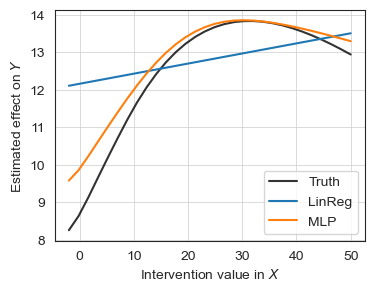

In [14]:
fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(111)
fig_ax = (fig, ax)

X = [(1, 0)]
Y = [(3, 0)]

# Ground truth
ax.plot(dox_vals, intervention_data[:, mask_dict[0][:,Y[0][0]]==False, Y[0][0]].mean(axis=1), 
    alpha=0.8,
    color = 'black',
    linestyle='solid',
    label="Truth")

# Estimation using LinearRegression
fit_predict_plot(X=X, Y=Y, graph=graph, dataframe=dataframe, 
                 estimator=LinearRegression(), 
                 dox_vals=dox_vals,
                 data_transform=None, 
                 graph_type='stationary_dag', 
                 adjustment_set='optimal', 
                 confidence=False,
                 seed=4,
                 label='LinReg',
                 fig_ax = fig_ax,
                 verbosity=0)

# Estimation using MLPRegressor
fit_predict_plot(X=X, Y=Y, graph=graph, dataframe=dataframe, 
                 estimator=MLPRegressor(random_state=2, max_iter=1000), 
                 dox_vals=dox_vals,
                 data_transform=None, 
                 graph_type='stationary_dag', 
                 adjustment_set='optimal', 
                 confidence=False,
                 seed=4,
                 label='MLP',
                 fig_ax = fig_ax,
                 verbosity=0)

ax.legend(loc='best', fontsize=10)

The linear regression fails while the MLP better estimates the nonlinear effect.

It is prudent to also estimate confidence intervals, this is implemented based on bootstrap here. The following cell can take a while:

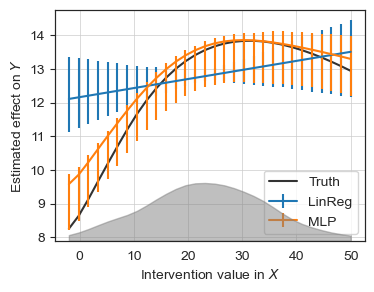

In [15]:
fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(111)
fig_ax = (fig, ax)

X = [(1, 0)]
Y = [(3, 0)]

# Ground truth
ax.plot(dox_vals, intervention_data[:, mask_dict[0][:,Y[0][0]]==False, Y[0][0]].mean(axis=1), 
    alpha=0.8,
    color = 'black',
    linestyle='solid',
    label="Truth")

# Estimation using LinearRegression
fit_predict_plot(X=X, Y=Y, graph=graph, dataframe=dataframe, 
                 estimator=LinearRegression(), 
                 dox_vals=dox_vals,
                 data_transform=None, 
                 graph_type='stationary_dag', 
                 adjustment_set='optimal', 
                 confidence=True,
                 boot_samples=50,
                 seed=4,
                 label='LinReg',
                 fig_ax = fig_ax,
                 verbosity=0)

# # Estimation using MLPRegressor
fit_predict_plot(X=X, Y=Y, graph=graph, dataframe=dataframe, 
                 estimator=MLPRegressor(random_state=2, max_iter=1000), 
                 dox_vals=dox_vals,
                 data_transform=None, 
                 graph_type='stationary_dag', 
                 adjustment_set='optimal', 
                 confidence=True,
                 boot_samples=50,
                 seed=4,
                 label='MLP',
                 fig_ax = fig_ax,
                 verbosity=0)

# Also show observational density of Tair
ax2 = ax.twinx()
x = dataframe.values[0][:, X[0][0]][dataframe.mask[0][:, X[0][0]]==False]
density = gaussian_kde(x[np.isnan(x)==False])
ax2.fill_between(dox_vals, 
    y1=np.zeros(len(dox_vals)), y2=density(dox_vals), 
    color='grey', alpha=0.5, label=r"$p(%s)$" %var_names[X[0][0]])
ax2.get_yaxis().set_ticklabels([])
ax2.get_yaxis().set_ticks([])
ax2.set_ylim(0, density(dox_vals).max()*4)
ax.legend(loc='best', fontsize=10)

The larger (bootstrap) confidence intervals at the left and right ends illustrate that the estimation worsens in regions with little training data (density shown in grey). As a side note: the graph was estimated via causal discovery from the same data as the effect was estimated and, therefore, the confidence intervals could be too small (see comment on post-selection inference in paper). A compromise would be to split the sample (via masking).

### Estimation using alternative assumption about graph

An alternative graph can be assumed where hidden confounding between Tair$_{t-1}$ and Reco$_t$ as well as between GPP$_{t}$ and Reco$_t$ is present. This hidden confounding is graphically represented by the bidirected edges Tair$_{t-1}$ $\leftrightarrow$ Reco$_t$ and GPP$_{t}\leftrightarrow$Reco$_t$, and it can emerge from other atmospheric and hydrological drivers. The causal effect in this modified hidden-variable graph (``graph_type='stationary_admg'``) can still be identified, but the optimal adjustment set changes:

In [16]:
graph = np.copy(original_graph)

# Add confounding links, '+->' indicates the existence of both a causal effect `-->` and confounding `<->`
graph[2,3,0] = '+->' ; graph[3,2,0] = '<-+'
graph[1,3,1] = '<->'

In [17]:
# We are interested in lagged total effect of X on Y
X = [(1, 0)]
Y = [(3, 0)]
causal_effects = CausalEffects(graph, graph_type='stationary_admg',
                    X=X, Y=Y, 
                   verbosity=0)

X = [('Tair', 0)] -----> Y = [('Reco', 0)]
Oset =  [('GPP', -1), ('Reco', -1), ('Rg', 0), ('Tair', -1), ('Rg', -1), ('Tair', -2)]
Optimality = True
Mediators = {(2, 0)}


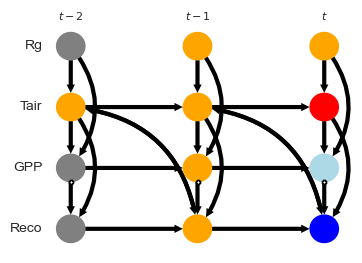

In [18]:
opt = causal_effects.get_optimal_set()
if opt is False: print("NOT IDENTIFIABLE!")
print("X = %s -----> Y = %s" % (str([(var_names[var[0]], var[1]) for var in X]), str([(var_names[var[0]], var[1]) for var in Y])))
print("Oset = ", [(var_names[v[0]], v[1]) for v in opt])
print("Optimality = %s" %str(causal_effects.check_optimality()))
print("Mediators = %s" %str(causal_effects.M))

special_nodes = {}
for node in causal_effects.X:
    special_nodes[node] = 'red'
for node in causal_effects.Y:
    special_nodes[node] = 'blue'
for node in opt:
    special_nodes[node] = 'orange'
for node in causal_effects.M:
    special_nodes[node] = 'lightblue'

link_width = None

fig, ax = tp.plot_time_series_graph(
    # graph = pcmcires['graph'],
    # val_matrix=pcmcires['val_matrix'],
    graph = causal_effects.stationary_graph,
    # graph = causal_effects.graph,
    link_width=link_width,
#     link_attribute=graph_attr,
    cmap_edges = 'RdBu_r',
    arrow_linewidth=3,
    curved_radius=0.4,
    node_size=0.15,
    special_nodes=special_nodes,
    var_names=var_names,
    link_colorbar_label='Cross-strength',
    figsize=(4, 3),
    )

Still the causal effect estimates are similar for the MLP (not for linear regression):

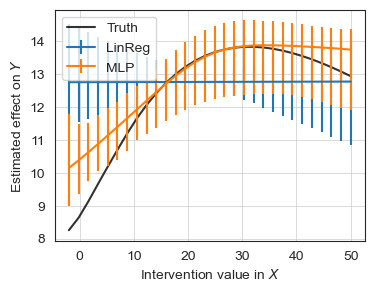

In [19]:
fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(111)
fig_ax = (fig, ax)

X = [(1, 0)]
Y = [(3, 0)]

# Ground truth
ax.plot(dox_vals, intervention_data[:, mask_dict[0][:,Y[0][0]]==False, Y[0][0]].mean(axis=1), 
    alpha=0.8,
    color = 'black',
    linestyle='solid',
    label="Truth")

# Estimation using LinearRegression
fit_predict_plot(X=X, Y=Y, graph=graph, dataframe=dataframe, 
                 estimator=LinearRegression(), 
                 dox_vals=dox_vals,
                 data_transform=None, 
                 graph_type='stationary_admg', 
                 adjustment_set='optimal', 
                 confidence=True,
                 boot_samples=50,
                 seed=4,
                 label='LinReg',
                 fig_ax = fig_ax,
                 verbosity=0)

# Estimation using MLPRegressor
fit_predict_plot(X=X, Y=Y, graph=graph, dataframe=dataframe, 
                 estimator=MLPRegressor(random_state=2, max_iter=1000), 
                 dox_vals=dox_vals,
                 data_transform=None, 
                 graph_type='stationary_admg', 
                 adjustment_set='optimal', 
                 confidence=True,
                 boot_samples=50,
                 seed=4,
                 label='MLP',
                 fig_ax = fig_ax,
                 verbosity=0)
ax.legend(loc='best', fontsize=10)

This analysis also demonstrates the importance to be more explicit and transparent in laying out assumptions that enable more robust conclusions and in assessing and discussing conclusions under alternative sets of assumptions. 


## Non-causal estimation

Finally, let's see which results we get for non-causal models without covariates ('-uni') and with all other variables as covariates ('-all').

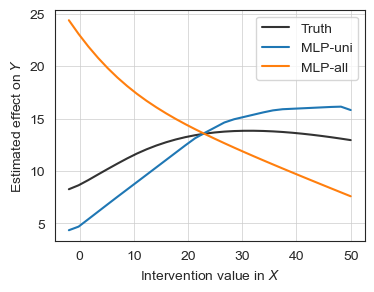

In [20]:
fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(111)
fig_ax = (fig, ax)

X = [(1, 0)]
Y = [(3, 0)]

all_conds = [(i, -tau) for i in range(N) for tau in range(0, graph.shape[2]) if (i, -tau) not in X and  (i, -tau) not in Y]

# Ground truth
ax.plot(dox_vals, intervention_data[:, mask_dict[0][:,Y[0][0]]==False, Y[0][0]].mean(axis=1), 
    alpha=0.8,
    color = 'black',
    linestyle='solid',
    label="Truth")

# Estimation without adjustment (nonlinear correlation)
fit_predict_plot(X=X, Y=Y, graph=graph, dataframe=dataframe, 
                 estimator=MLPRegressor(random_state=2, max_iter=1000), 
                 dox_vals=dox_vals,
                 data_transform=None, 
                 graph_type='stationary_admg', 
                 adjustment_set=[], 
                 confidence=False,
                 boot_samples=50,
                 seed=4,
                 label='MLP-uni',
                 fig_ax = fig_ax,
                 verbosity=0)

# Estimation with all other variables
fit_predict_plot(X=X, Y=Y, graph=graph, dataframe=dataframe, 
                 estimator=MLPRegressor(random_state=2, max_iter=1000), 
                 dox_vals=dox_vals,
                 data_transform=None, 
                 graph_type='stationary_admg', 
                 adjustment_set=all_conds, 
                 confidence=False,
                 boot_samples=50,
                 seed=4,
                 label='MLP-all',
                 fig_ax = fig_ax,
                 verbosity=0)
ax.legend(loc='best', fontsize=10)

The '-uni' approach suffers from confounding and the '-all' approach blocks the mediator GPP$_t$, both lead to biased estimates.
 
Have a look at other tutorials on various methods and functionality of tigramite.